In [1]:
import tensorflow as tf
from keras.layers import Conv2D, LeakyReLU, Input, MaxPooling2D, Activation, Concatenate, Dropout, Lambda, Add, UpSampling2D
from keras.models import Model, Sequential
import keras
import matplotlib.pyplot as plt
from tensorflow.data import AUTOTUNE
import uuid

## Get data set objects together

In [ ]:
#Environmnet stuff
from cycleganstyletransfer.config import DATA_DIR
data_dir = DATA_DIR / "raw"

monet_path = data_dir / "Monet"
image_path = data_dir / "Images"


In [2]:
#Make the datasets
my_monet_ds_train, my_monet_ds_val = tf.keras.utils.image_dataset_from_directory(
    monet_path,
    validation_split=0.1,
    subset="both",
    seed=42,
    image_size=(128, 128),
    batch_size = 1,
    labels = None,
)

my_image_ds_train, my_image_ds_val = tf.keras.utils.image_dataset_from_directory(
    image_path,
    validation_split=0.1,
    subset="both",
    seed=42,
    image_size=(128, 128),
    batch_size = 1,
    labels = None,
)

DATASET_HEIGHT = max(len(my_monet_ds_train), len(my_image_ds_train))

2025-06-17 18:23:21.355 | INFO     | cycleganstyletransfer.config:<module>:11 - PROJ_ROOT path is: C:\Users\willi\Desktop\AIPortfolio\CycleGanV2\cycleganstyletransfer


Found 1193 files belonging to 1 classes.
Using 1074 files for training.
Using 119 files for validation.
Found 7037 files belonging to 1 classes.
Using 6334 files for training.
Using 703 files for validation.


In [ ]:
#Pre processing
def augment_and_normalize(image):
    image = tf.cast(image, tf.float32)  # convert from uint8
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=20)  # for 0–255 range
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.clip_by_value(image, 0.0, 255.0)
    image = image / 127.5 - 1.0  # scale to [-1, 1]
    return image


In [ ]:

my_monet_ds_train = (
  my_monet_ds_train
  .map(augment_and_normalize, num_parallel_calls=AUTOTUNE)
  .cache()
  .shuffle(1000)
  .repeat()
  .prefetch(AUTOTUNE)
)

my_image_ds_train = (
  my_image_ds_train
  .map(augment_and_normalize, num_parallel_calls=AUTOTUNE)
  .cache()
  .shuffle(1000)
  .repeat()
  .prefetch(AUTOTUNE)
)

my_monet_ds_train = iter(my_monet_ds_train)
my_image_ds_train = iter(my_image_ds_train)

## Define an Instance norm Layer

In [5]:
class InstanceNormalization(keras.layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        # One scale and bias per channel
        self.gamma = self.add_weight(
            shape=(input_shape[-1],),
            initializer='ones',
            trainable=True,
            name='gamma'
        )
        self.beta = self.add_weight(
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True,
            name='beta'
        )
        super(InstanceNormalization, self).build(input_shape)

    def call(self, inputs):
        # Compute mean and variance per instance, per channel
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        return self.gamma * normalized + self.beta

    def get_config(self):
        config = super().get_config().copy()
        config.update({"epsilon": self.epsilon})
        return config


## Put the Discrim model together

In [24]:
def build_discriminator(input_shape=(128, 128, 3)):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(512, kernel_size=4, strides=1, padding='same')(x)
    x = InstanceNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(1, kernel_size=4, strides=1, padding='same')(x)

    return Model(inputs, x, name='PatchGAN_70x70')

my_patchgan_discriminator = build_discriminator()
my_patchgan_discriminator.summary()


Model: "PatchGAN_70x70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_148 (Conv2D)         (None, 64, 64, 64)        3136      
                                                                 
 leaky_re_lu_27 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 conv2d_149 (Conv2D)         (None, 32, 32, 128)       131200    
                                                                 
 instance_normalization_127  (None, 32, 32, 128)       256       
  (InstanceNormalization)                                        
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                    

## Generator model

In [25]:
# === Reflection Padding ===
def ReflectionPad2D(pad):
    return Lambda(lambda x: tf.pad(x, [[0, 0], [pad, pad], [pad, pad], [0, 0]], mode='REFLECT'))

In [26]:
# === Residual Block ===
def ResidualBlock(filters, kernel_size=3):
    pad = kernel_size // 2
    def block(x):
        y = ReflectionPad2D(pad)(x)
        y = Conv2D(filters, kernel_size, padding='valid')(y)
        y = InstanceNormalization()(y)
        y = Activation('relu')(y)

        y = ReflectionPad2D(pad)(y)
        y = Conv2D(filters, kernel_size, padding='valid')(y)
        y = InstanceNormalization()(y)

        return Add()([x, y])
    return block
##No activation at the end ?!

In [27]:
def Generator(input_shape=(128, 128, 3), n_res_blocks=6):
    inputs = Input(shape=input_shape)

    # Encoder
    x = ReflectionPad2D(3)(inputs)
    x = Conv2D(64, kernel_size=7, padding='valid')(x)
    x = InstanceNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = Activation('relu')(x)

    # Residual Blocks
    for _ in range(n_res_blocks):
        x = ResidualBlock(256)(x)

    # Decoder
    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    x = Conv2D(128, kernel_size=3, padding='same')(x)
    x = InstanceNormalization()(x)
    x = Activation('relu')(x)

    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    x = Conv2D(64, kernel_size=3, padding='same')(x)
    x = InstanceNormalization()(x)
    x = Activation('relu')(x)

    x = ReflectionPad2D(3)(x)
    x = Conv2D(3, kernel_size=7, padding='valid', activation='tanh')(x)

    return Model(inputs, x, name='JohnsonGenerator')

# Example:
gen = Generator(input_shape=(128,128,3))
gen.summary()

Model: "JohnsonGenerator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 lambda_87 (Lambda)          (None, 134, 134, 3)          0         ['input_18[0][0]']            
                                                                                                  
 conv2d_153 (Conv2D)         (None, 128, 128, 64)         9472      ['lambda_87[0][0]']           
                                                                                                  
 instance_normalization_130  (None, 128, 128, 64)         128       ['conv2d_153[0][0]']          
  (InstanceNormalization)                                                          

## Loss functions

In [11]:

#L2 Loss function
def my_square_loss(y_true, y_pred):
    y_true = tf.cast(y_true, y_pred.dtype)
    return tf.reduce_mean(tf.square(y_true - y_pred))

#Generator loss function
def generator_loss(descrim_output):
        return tf.reduce_mean(tf.math.squared_difference(tf.ones_like(descrim_output), descrim_output))


## Image buffer to stabilise training

In [13]:
import numpy as np

class ImageBuffer:
    """
    Implements a buffer that stores previously generated images.
    When queried, it returns a mix of old and new images.
    """
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.data = []

    def query(self, image):
        if len(self.data) < self.max_size:
            # Buffer not full: store and return current fake
            self.data.append(image)
            return image
        else:
            if np.random.rand() > 0.5:
                # Use buffer: pick old, swap with current
                idx = np.random.randint(0, self.max_size)
                old_image = self.data[idx]
                self.data[idx] = image
                return old_image
            else:
                # Use current fake
                return image


## Adding Alternating trainin

In [ ]:
# Set up TensorBoard logging
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

# Create metrics to track losses
gen_m_loss_metric = tf.keras.metrics.Mean('gen_m_loss', dtype=tf.float32)
gen_p_loss_metric = tf.keras.metrics.Mean('gen_p_loss', dtype=tf.float32) 
disc_m_loss_metric = tf.keras.metrics.Mean('disc_m_loss', dtype=tf.float32)
disc_p_loss_metric = tf.keras.metrics.Mean('disc_p_loss', dtype=tf.float32)
cycle_loss_metric = tf.keras.metrics.Mean('cycle_loss', dtype=tf.float32)
identity_loss_metric = tf.keras.metrics.Mean('identity_loss', dtype=tf.float32)
total_loss_metric = tf.keras.metrics.Mean('total_loss', dtype=tf.float32)

In [14]:
def to_display(img):
    return (img[0] + 1) / 2 #* 0.5 + 0.5#tf.clip_by_value(img * 0.5 + 0.5, 0.0, 1.0)

In [15]:
from keras.optimizers import Adam
import numpy as np
import time

NUM_EPOCHS = 5
EPOCH_LENGTH = DATASET_HEIGHT
DISPLAY_INTERVAL = 15  # record loss every 5 steps

# Optimizers for all models
monet_gen_opt = Adam(learning_rate=2e-4, beta_1=0.5)
photo_gen_opt = Adam(learning_rate=2e-4, beta_1=0.5)
monet_disc_opt = Adam(learning_rate=2e-4, beta_1=0.5)
photo_disc_opt = Adam(learning_rate=2e-4, beta_1=0.5)

# Initialize models
monet_generator = Generator((128, 128, 3))
photo_generator = Generator((128, 128, 3))
monet_discriminator = build_discriminator()
photo_discriminator = build_discriminator()

eg_image = augment_and_normalize(next(my_image_ds_train))
eg_output = monet_generator(eg_image)

# Create buffers for each fake domain
monet_fake_buffer = ImageBuffer(max_size=50)
photo_fake_buffer = ImageBuffer(max_size=50)


In [16]:
@tf.function
def train_step(monet_image, photo_image):
    with tf.GradientTape(persistent=True) as tape:
        # === Generate fakes ===
        fake_monet = monet_generator(photo_image, training=True)
        fake_photo = photo_generator(monet_image, training=True)

        # === Cycle back ===
        cycled_photo = photo_generator(fake_monet, training=True)
        cycled_monet = monet_generator(fake_photo, training=True)

        # === Identity mapping ===
        same_monet = monet_generator(monet_image, training=True)
        same_photo = photo_generator(photo_image, training=True)

        # === Discriminator real ===
        disc_real_monet = monet_discriminator(monet_image, training=True)
        disc_real_photo = photo_discriminator(photo_image, training=True)

        # === Use buffer for discriminator fakes ===
        fake_monet_for_disc = monet_fake_buffer.query(fake_monet)
        fake_photo_for_disc = photo_fake_buffer.query(fake_photo)

        disc_fake_monet = monet_discriminator(fake_monet_for_disc, training=True)
        disc_fake_photo = photo_discriminator(fake_photo_for_disc, training=True)

        # === Losses ===
        monet_disc_loss = 0.5 * (
            my_square_loss(tf.ones_like(disc_real_monet), disc_real_monet) +
            my_square_loss(tf.zeros_like(disc_fake_monet), disc_fake_monet)
        )
        photo_disc_loss = 0.5 * (
            my_square_loss(tf.ones_like(disc_real_photo), disc_real_photo) +
            my_square_loss(tf.zeros_like(disc_fake_photo), disc_fake_photo)
        )

        monet_gen_loss = my_square_loss(tf.ones_like(
            monet_discriminator(fake_monet, training=True)
        ), monet_discriminator(fake_monet, training=True))
        photo_gen_loss = my_square_loss(tf.ones_like(
            photo_discriminator(fake_photo, training=True)
        ), photo_discriminator(fake_photo, training=True))

        cycle_loss = tf.reduce_mean(tf.abs(photo_image - cycled_photo)) + \
                     tf.reduce_mean(tf.abs(monet_image - cycled_monet))

        identity_loss = tf.reduce_mean(tf.abs(monet_image - same_monet)) + \
                        tf.reduce_mean(tf.abs(photo_image - same_photo))

        total_monet_gen_loss = monet_gen_loss + 5 * cycle_loss + 2 * identity_loss
        total_photo_gen_loss = photo_gen_loss + 5 * cycle_loss + 2 * identity_loss

    # === Apply gradients ===
    monet_disc_grads = tape.gradient(monet_disc_loss, monet_discriminator.trainable_variables)
    photo_disc_grads = tape.gradient(photo_disc_loss, photo_discriminator.trainable_variables)
    monet_gen_grads = tape.gradient(total_monet_gen_loss, monet_generator.trainable_variables)
    photo_gen_grads = tape.gradient(total_photo_gen_loss, photo_generator.trainable_variables)

    monet_disc_opt.apply_gradients(zip(monet_disc_grads, monet_discriminator.trainable_variables))
    photo_disc_opt.apply_gradients(zip(photo_disc_grads, photo_discriminator.trainable_variables))
    monet_gen_opt.apply_gradients(zip(monet_gen_grads, monet_generator.trainable_variables))
    photo_gen_opt.apply_gradients(zip(photo_gen_grads, photo_generator.trainable_variables))

    return (
        monet_disc_loss, photo_disc_loss,
        monet_gen_loss, photo_gen_loss,
        cycle_loss, identity_loss
    )


Epoch 1/5
Step 1/6334 M-disc: 1.1686, P-disc: 1.4522, M-gen: 1.8226, P-gen: 1.0169, Cycle: 1.1539, Identity: 1.1113

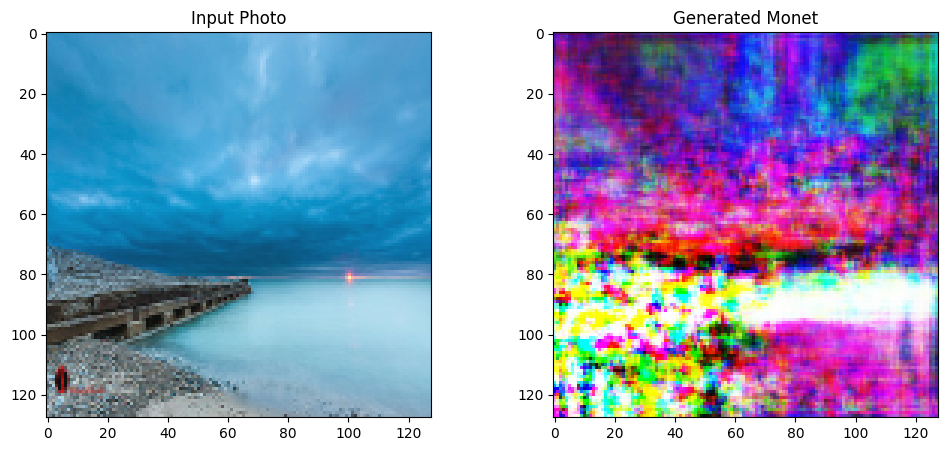

Step 19/6334 M-disc: 0.5018, P-disc: 0.5541, M-gen: 0.5729, P-gen: 0.5291, Cycle: 0.8624, Identity: 0.8001

KeyboardInterrupt: 

In [17]:
all_losses = []

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    epoch_losses = []
    start_time = time.time()

    for step in range(EPOCH_LENGTH):
        monet_image = next(my_monet_ds_train)
        photo_image = next(my_image_ds_train)

        losses = train_step(monet_image, photo_image)

        if step % DISPLAY_INTERVAL == 0:
            loss_vals = [tf.squeeze(l).numpy() for l in losses]
            epoch_losses.append(loss_vals)
        print(f"\rStep {step+1}/{EPOCH_LENGTH} "
                f"M-disc: {loss_vals[0]:.4f}, P-disc: {loss_vals[1]:.4f}, "
                f"M-gen: {loss_vals[2]:.4f}, P-gen: {loss_vals[3]:.4f}, "
                f"Cycle: {loss_vals[4]:.4f}, Identity: {loss_vals[5]:.4f}", end='')

        if step % 100 == 0:
            test_photo_to_monet = monet_generator(photo_image, training=False)
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(to_display(photo_image))
            plt.title('Input Photo')
            plt.subplot(1, 2, 2)
            plt.imshow(to_display(test_photo_to_monet))
            plt.title('Generated Monet')
            plt.show()
            plt.close()

    avg_losses = np.mean(epoch_losses, axis=0)
    print(f"\nEpoch {epoch + 1} done in {int(time.time()-start_time)}s. "
          f"Avg M-disc: {avg_losses[0]:.4f} P-disc: {avg_losses[1]:.4f} "
          f"M-gen: {avg_losses[2]:.4f} P-gen: {avg_losses[3]:.4f} "
          f"Cycle: {avg_losses[4]:.4f} Identity: {avg_losses[5]:.4f}")
    all_losses.extend(epoch_losses)
